## _*Circuit Descriptors*_

#### Written by Hojun Lee


### Introduction
Parameterized quantum circuit(PQC) can be the framework of variational quantum algorithms.

[1] presented two circuit descriptors of parameterized quantum circuit, expressibility and entangling capability.

To learn how to implement parameterized quantum circuits, see [this file](https://qiskit.org/documentation/tutorials/circuits_advanced/01_advanced_circuits.html).

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
from scipy.stats import rv_continuous
from qiskit.circuit import Parameter, ParameterVector
from qiskit import *
from sklearn.metrics.cluster import adjusted_mutual_info_score as mi

### Make a parameterized quantum circuit

This PQC class has a method `get()` which returns statevector by using statevector simulator.

It has two modes, "pqc" and "random".

In "pqc" mode, it samples parameter values from unifrom distribution and bind it to the parameterized quantum circuit.

"random" mode is for random quantum circuits. it uses `qiskit.quantum_info.random_unitary` which samples unitary operator from the unitary Haar measure.

In [2]:
class PQC:
    def __init__(self,name,size,num_params,backend=Aer.get_backend('statevector_simulator')):
        self.backend = backend
        self.circ = QuantumCircuit(size)
        self.name = name
        self.size = size
        self.num_params = num_params
        seed = 14256
        np.random.seed(seed)
        self.params = ParameterVector('θ', self.num_params)
    def get(self,mode="pqc"):
        if mode == "pqc":
            circ = self.circ.bind_parameters({self.params: np.random.uniform(0,2*np.pi,len(self.params.params))})
        elif mode == "random":
            rand = qiskit.quantum_info.random_unitary(dims=2**self.size)
            circ = QuantumCircuit(self.size)
            circ.data = self.circ.data
            circ.append(rand,range(self.size))
        result = execute(circ,self.backend).result()
        out_state = result.get_statevector()
        statevector = np.asmatrix(out_state).T
        return statevector

Following quantum circuit is similar from with `Circuit 19` in [1]

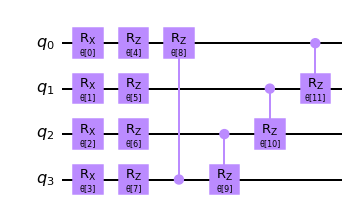

In [3]:
pqc = PQC(name="MyCirc",size=4,num_params=12)
for i in range(pqc.size):
    pqc.circ.rx(pqc.params[i],i)
for i in range(pqc.size):
    pqc.circ.rz(pqc.params[i+pqc.size],i)
pqc.circ.crz(pqc.params[2*pqc.size],pqc.size-1,0)
for i in range(pqc.size-1):
    pqc.circ.crz(pqc.params[i+1+2*pqc.size],pqc.size-i-2,pqc.size-i-1)
pqc.circ.draw('mpl')

`get()` method returns the statevector

In [4]:
pqc.get(mode="pqc")

matrix([[ 0.12530701+1.27546047e-02j],
        [-0.16961975+1.54238235e-01j],
        [-0.0044316 +3.40098926e-03j],
        [-0.0032801 -9.62435063e-03j],
        [-0.27942712+3.34385164e-01j],
        [-0.11325471-7.85049126e-01j],
        [-0.0040606 +1.88953655e-02j],
        [-0.03021272-1.80194588e-02j],
        [ 0.04366029+8.41178169e-03j],
        [ 0.0782669 -2.05952042e-02j],
        [-0.00166481+1.05695980e-03j],
        [-0.00054407+3.54791646e-03j],
        [ 0.14319123+5.62141380e-02j],
        [ 0.27924256-2.05741649e-02j],
        [ 0.00678106-7.51180781e-04j],
        [ 0.0070887 -1.01962833e-02j]])

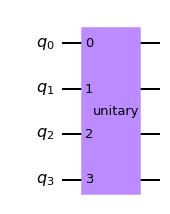

In [5]:
pqcr = PQC(name="rand",size=4,num_params=0)
rand = qiskit.quantum_info.random_unitary(dims=2**pqcr.size)
circ = QuantumCircuit(pqcr.size)
circ.data = pqcr.circ.data
circ.append(rand,range(pqcr.size))
circ.draw('mpl')


In [6]:
pqcr.get(mode="random")

matrix([[-3.98714123e-02+0.13250183j],
        [ 1.25384717e-01+0.01745208j],
        [ 4.11904779e-02-0.04681158j],
        [-2.26546495e-01-0.184279j  ],
        [ 8.92090819e-02-0.12638076j],
        [-6.45155493e-05+0.14151557j],
        [ 2.90019967e-02+0.28616342j],
        [ 1.06946742e-01-0.25793945j],
        [ 2.84696075e-01-0.1614268j ],
        [-1.26314751e-02-0.02909431j],
        [ 2.91752140e-01+0.17953406j],
        [ 1.76719194e-01-0.33373948j],
        [-3.14102597e-01-0.19002397j],
        [ 1.13760790e-03+0.37750962j],
        [-1.14572826e-02+0.05289444j],
        [ 1.20602728e-01-0.09033893j]])

### Expressibility

Expressibility is a measure of how the quantum states generated by parameterized quantum circuit represent Hilbert space well.

To quantify this non-uniformity, [1] looked $\epsilon$-approximate state $t$-design.
$\begin{equation*}
A=\int_{Haar}\left(|\psi\rangle\langle\psi|\right)^{\otimes t} d\psi - \int_{\mathbf{\Theta}}\left(|\psi_\mathbf{\theta}\rangle\langle\psi_\mathbf{\theta}|\right)^{\otimes t} d\mathbf{\theta}
\end{equation*}$

And $||A||_{HS}^2$ can thought as one of the measure of non-uniformity. ($HS$ is Hilbert-Schmidt norm)

$||A||_{HS}^2$ can be expressed as a term of `frame potential`[2] $\mathcal{F}^{(t)}$

$\begin{equation*}
||A||_{HS}^2 = \mathcal{F}^{(t)} - \mathcal{F}_{Haar}^{(t)}
\end{equation*}$

$\begin{equation*}
\mathcal{F}^{(t)} = \int_{\mathbf{\Theta}}\int_{\mathbf{\Phi}}{\left|\langle\psi_{\mathbf{\theta}}|\psi_{\mathbf{\phi}}\rangle\right|}^{2t} d\mathbf{\theta}d\mathbf{\phi},\ \ \ \mathcal{F}_{Haar}^{(t)} = {{1}\over{d_{sym}^{(t)}}} = {{t! (N-1)!}\over{(t+N-1)!}}
\end{equation*}$

where $N=2^n$ for $n$ qubits.

Since $||A||_{HS}^2\ge 0$, $\mathcal{F}^{(t)}$ has a lower bound $\mathcal{F}_{Haar}^{(t)}$

$\mathcal{F}^{(t)}$ can be understood as $t$-th momentum of the distribution of fidelity.

$\begin{equation*}
\mathcal{F}^{(t)} = \mathbb{E}\left[F^t\right], \ \ \ F={\left|\langle\psi_{\mathbf{\theta}}|\phi_{\mathbf{\theta}}\rangle\right|}^2
\end{equation*}$

And expressibility is defined as the Kullback-Leibler(KL) divergence of estimated fidelity distribution and fidelity distribution of the Haar distribution.

$\begin{equation*}
Expr = D_{KL}\left(\hat{P}_{PQC}(F;\mathbf{\theta})||P_{Haar}(F)\right)
\end{equation*}$

And the probability of haar distribution is known as $P_{Haar}(F) = (N-1){(1-F)}^{N-2}$

### Implement expressibility function

We can estimate the probability distribution function with histogram of sampled fidelities.

Natural logarithm is used in Kullback-Leibler divergence.

In [7]:
def kl_divergence(p, q):
    return np.sum(np.where(p*q!=0, p * np.log(p / q), 0))

def Haar(F,N):
    if F<0 or F>1:
        return 0;
    return (N-1)*((1-F)**(N-2))

class Haar_dist(rv_continuous):
    def _pdf(self,x,n):
        return Haar(x,2**n)

def getHaar(reps,bins=250,qubits=4):
    haar = []
    N = qubits ** 2
    for i in range(bins):
        haar.append(Haar((i+0.5)/bins,N)/bins)
    return np.array(haar)
def expressibility(pqc, bins=250, reps=10000, verbose = 2, get_mode="pqc"):
    arr = []
    for i in range(reps):
        v1 = pqc.get(mode=get_mode).getH()
        v2 = pqc.get(mode=get_mode)
        fid = np.abs(v1*v2)**2
        arr.append(fid[0,0])
        if verbose == 2:
            if i%100==0 and i!=0:
                print("\r","reps ",i,end=' ')
            if i==reps-1:
                print("\rdone.",end=' ')
    haar = []
    h = Haar_dist(a=0,b=1,name="haar")
    for i in range(reps):
        haar.append(h.ppf((i+1)/reps,pqc.size))
    haar_pdf = plt.hist(np.array(haar), bins=bins, alpha=0.5,range=(0,1),density=True,label="haar")[0]
    pqc_pdf = plt.hist(np.array(arr), bins=bins, alpha=0.5, range=(0,1),density=True,label=get_mode)[0]
    kl = kl_divergence(pqc_pdf/bins,haar_pdf/bins)
    if verbose >= 1:
        plt.title("%s KL(P||Q) = %1.4f" % (pqc.name, kl))
        plt.legend()
    return kl

Calculate the expressibility of `pqc`

In [8]:
expressibility(pqc,reps=1000,get_mode='pqc')

 reps  200 

You can see that the random quantum circuit has much lower value than parameterized quantum circuits. The expressibility of random quantum circuit is ideally 0.

In [ ]:
expressibility(pqcr,reps=1000,get_mode='random')

### Entangling capability

Entangling capability is the average of Meyer-Wallach entanglement[3] of states generated by the parameterized quantum circuit.

$Ent. = {1\over{|S|}}\sum\limits_{\boldsymbol{\theta_i}\in S}Q(|\psi_{{\boldsymbol{\theta_i}}}\rangle)$

For pure states, we can calculate the Meyer-Wallach entanglement as following.[4]

$Q(|\psi\rangle) = {4\over n}\sum\limits_{j=1}^n D(\iota_j(0)|\psi\rangle,\iota_j(1)|\psi\rangle)$

$D(|u\rangle, |v\rangle) = {1\over 2}\sum\limits_{i,j}{|u_iv_j-u_jv_i|}^2$

$\iota_j(b)|b_1 b_2 \cdots b_n\rangle = \delta_{bb_j}|b_1 b_2 \cdots\hat{b_j}\cdots b_n\rangle$

where the symbol ^ denotes absence of the $j$-th qubit.

In [ ]:
def I(b,j,n,vec):
    newvec = np.zeros((2**(n-1)), dtype=complex)
    for new_index in range(2**(n-1)):
        original_index = new_index%(2**(j-1)) + (new_index//(2**(j-1)))*(2**(j)) + b*(2**(j-1))
        newvec[new_index]=vec[int(original_index),0]
    return newvec


def D(u,v,m):
    dist = 0
    for i in range(m):
        for j in range(m):
            a = u[i]*v[j]-u[j]*v[i]
            dist += (1/2)*(np.abs(a)**2)
    return dist


def Q(n,vec):
    sum = 0;
    for j in range(n):
        sum += D(I(0,j+1,n,vec),I(1,j+1,n,vec),2**(n-1))
    return sum * 4 / n


def entangling_capability(pqc, reps=10000,verbose=1,get_mode="pqc"):
    sum = 0;
    for i in range(reps):
        sum += Q(pqc.size,pqc.get(mode=get_mode))
        if verbose == 1:
            if i%100==0 and i!=0:
                print("\r","reps ",i,end=' ')
            if i==reps-1:
                print("\rdone.",end=' ')
    return sum/reps

In [ ]:
entangling_capability(pqc,reps=1000)

The mean $Q$ value of Haar random states are known as $\langle Q\rangle_{Haar} = {{N-2}\over{N+1}}$ where $N=2^n$ [5]

In [ ]:
N = 2**pqcr.size
Q_haar = (N-2)/(N+1)
print(Q_haar)

In [ ]:
entangling_capability(pqcr,reps=1000,get_mode="random")

### Get expressibility with qasm_simulator
For pure quantum states, we can get fidelity with swap test [6]

In [ ]:
def get_fidelity(pqc):
    backend = Aer.get_backend('qasm_simulator')
    qc = QuantumCircuit(2*pqc.size + 1,1)
    circ1 = pqc.circ.copy()
    circ2 = pqc.circ.copy()
    circ1 = circ1.bind_parameters({pqc.params: np.random.uniform(0,2*np.pi,len(pqc.params.params))})
    circ2 = circ2.bind_parameters({pqc.params: np.random.uniform(0,2*np.pi,len(pqc.params.params))})
    circ1.name="pqc"
    circ2.name="pqc"
    qc.h(0)
    qc.append(circ1,range(1,1+pqc.size))
    qc.append(circ2,range(1+pqc.size,1+2*pqc.size))
    for i in range(pqc.size):
        qc.cswap(0,i+1,i+1+pqc.size)
    qc.h(0)
    qc.measure(0,0)
    shots = 10000
    result = execute(qc,backend,shots=shots).result()
    counts = result.get_counts()
    fid = 2*(counts['0']/shots)-1
    fid = fid if fid>0 else 0
    return (qc, fid)

In [ ]:
qc,fid=get_fidelity(pqc)
print(fid)
qc.draw('mpl')

In [ ]:
def expressibility_swap(pqc, bins=250, reps=10000, verbose = 2):
    arr = []
    for i in range(reps):
        _, fid = get_fidelity(pqc)
        arr.append(fid)
        if verbose == 2:
            if i%100==0 and i!=0:
                print("\r","reps ",i,end=' ')
            if i==reps-1:
                print("\rdone.",end=' ')
    haar = []
    h = Haar_dist(a=0,b=1,name="haar")
    for i in range(reps):
        haar.append(h.ppf((i+1)/reps,pqc.size))
    haar_pdf = plt.hist(np.array(haar), bins=bins, alpha=0.5,range=(0,1),density=True,label="haar")[0]
    pqc_pdf = plt.hist(np.array(arr), bins=bins, alpha=0.5, range=(0,1),density=True,label="pqc")[0]
    kl = kl_divergence(pqc_pdf/bins,haar_pdf/bins)
    if verbose >= 1:
        plt.title("%s KL(P||Q) = %1.4f" % (pqc.name, kl))
        plt.legend()
    return kl

In [ ]:
expressibility_swap(pqc,reps=1000)

### References
1. Sim, Sukin, Peter D. Johnson, and Alán Aspuru‐Guzik. "Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum‐classical algorithms." Advanced Quantum Technologies 2.12 (2019): 1900070.
2. Roberts, Daniel A., and Beni Yoshida. "Chaos and complexity by design." Journal of High Energy Physics 2017.4 (2017): 1-64.
3. Meyer, David A., and Nolan R. Wallach. "Global entanglement in multiparticle systems." Journal of Mathematical Physics 43.9 (2002): 4273-4278.
4. Brennen, Gavin K. "An observable measure of entanglement for pure states of multi-qubit systems." arXiv preprint quant-ph/0305094 (2003).
5. Scott, Andrew J., and Carlton M. Caves. "Entangling power of the quantum baker's map." Journal of Physics A: Mathematical and General 36.36 (2003): 9553.
6. Wikipedia, Swap_test, https://en.wikipedia.org/wiki/Swap_test